In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# 1. 讀取資料

In [2]:
def read_files(root):
    dataset = {}
    files = list(glob.glob(os.path.join(root, "*.csv")))
    for file_path in files:
        print(f'read file:{file_path}')
        code = file_path.replace('stock_data\\','').replace('.csv','')
        df = pd.read_csv(file_path, index_col='date')
        df.sort_index(inplace=True)
        dataset[code] = df
    
    return dataset

In [3]:
ds = read_files('stock_data')

read file:stock_data\0056.csv
read file:stock_data\1101.csv
read file:stock_data\2327.csv
read file:stock_data\2352.csv
read file:stock_data\2385.csv
read file:stock_data\2449.csv
read file:stock_data\2915.csv
read file:stock_data\3005.csv
read file:stock_data\3532.csv
read file:stock_data\6176.csv
read file:stock_data\9945.csv


In [4]:
ds.keys()

dict_keys(['0056', '1101', '2327', '2352', '2385', '2449', '2915', '3005', '3532', '6176', '9945'])

In [5]:
len(ds.values())

11

### 觀察0056.csv裡面有157筆空值，是我們要預測的

In [6]:
ds['0056'].isna().sum()

0056_close_y    157
dtype: int64

# 2. 開始觀察資料、缺失值

In [7]:
# 觀察資料...

# 3. 補值

In [8]:
def fill_values(datasets):
    for stock_no, stock_df in datasets.items():
        if stock_no != '0056':
            # 增加欄位-昨日收盤價 close_y
            stock_df[f'{stock_no}_close_y'] = stock_df[f'{stock_no}_close'].shift(1)
            # 增加欄位-明日開盤價 open_t
            stock_df[f'{stock_no}_open_t'] = stock_df[f'{stock_no}_open'].shift(-1)
            
            # 補開盤價 open = close_y (用昨天的收盤價)
            stock_df[f'{stock_no}_open'].fillna(stock_df[f'{stock_no}_close_y'], inplace=True)

            # 補收盤價 close = ups_and_downs + close_y 
            stock_df[f'{stock_no}_close'].fillna(stock_df[f'{stock_no}_close_y']+stock_df[f'{stock_no}_ups_and_downs'], inplace=True)
            
            # 補收盤價 close = open_t (用明天的開盤價)
            stock_df[f'{stock_no}_close'].fillna(stock_df[f'{stock_no}_open_t'], inplace=True)

            # 補EPS
            stock_df[f'{stock_no}_eps'].fillna(method='ffill', inplace=True) #用昨天的來補
            #stock_df[f'{stock_no}_eps'].fillna(method='bfill', inplace=True) #用明天的來補

            # 補股價變動 close - close_y
            stock_df[f'{stock_no}_ups_and_downs'].fillna(stock_df[f'{stock_no}_close']-stock_df[f'{stock_no}_close_y'], inplace=True)

            # 補漲跌百分比 Close-Open / close_y
            stock_df[f'{stock_no}_ups_percent'].fillna(stock_df[f'{stock_no}_ups_and_downs']/stock_df[f'{stock_no}_close_y'], inplace=True)

            # 補成交金額 turnover = volumn * ((high+low)/2)
            stock_df[f'{stock_no}_Turnover'].fillna(stock_df[f'{stock_no}_Volume']*((stock_df[f'{stock_no}_high']+stock_df[f'{stock_no}_low'])/2), inplace=True)

            # 補成交量 volumn = turnover / ((high+low)/2)
            stock_df[f'{stock_no}_Volume'].fillna(stock_df[f'{stock_no}_Turnover']/((stock_df[f'{stock_no}_high']+stock_df[f'{stock_no}_low'])/2), inplace=True)

            # 補今日高點 high = (turnover / volumn)*2 - low
            stock_df[f'{stock_no}_high'].fillna((stock_df[f'{stock_no}_Turnover']/stock_df[f'{stock_no}_Volume'])*2-stock_df[f'{stock_no}_low'], inplace=True)

            # 補今日低點 low = (turnover / volumn)*2 - high
            stock_df[f'{stock_no}_low'].fillna((stock_df[f'{stock_no}_Turnover']/stock_df[f'{stock_no}_Volume'])*2-stock_df[f'{stock_no}_high'], inplace=True)
        
            # 補今日高點 high
            stock_df[f'{stock_no}_high'].fillna(method='bfill', inplace=True)
            
            # 補今日低點 low
            stock_df[f'{stock_no}_low'].fillna(method='bfill', inplace=True)

# 4. 移除不需要的特徵(欄位)

In [9]:
def remove_features(datasets):
    for stock_no, stock_df in datasets.items():
        if stock_no != '0056':
            # 移除不要的特徵(欄位)
            stock_df.drop(columns=[f'{stock_no}_close_y', f'{stock_no}_open_t'], inplace=True)
            stock_df.drop(columns=[f'{stock_no}_high', f'{stock_no}_low'], inplace=True)
            stock_df.drop(columns=[f'{stock_no}_Turnover', f'{stock_no}_Volume'], inplace=True)
            stock_df.drop(columns=[f'{stock_no}_open'], inplace=True)
            stock_df.drop(columns=[f'{stock_no}_ups_and_downs'], inplace=True)
            stock_df.drop(columns=[f'{stock_no}_ups_percent'], inplace=True)
            #stock_df.drop(columns=[f'{stock_no}_eps'], inplace=True)

In [10]:
fill_values(ds)
remove_features(ds)

### 觀察補完值後，每個資料集的缺失值情形

In [11]:
for stock_no, stock_df in ds.items():
    if stock_no != '0056':
        print(stock_df.isna().sum())

1101_close    1
1101_eps      0
dtype: int64
2327_close    8
2327_eps      0
dtype: int64
2352_close    0
2352_eps      0
dtype: int64
2385_close    0
2385_eps      0
dtype: int64
2449_close    0
2449_eps      0
dtype: int64
2915_close    6
2915_eps      0
dtype: int64
3005_close    0
3005_eps      0
dtype: int64
3532_close    7
3532_eps      0
dtype: int64
6176_close    0
6176_eps      0
dtype: int64
9945_close    6
9945_eps      0
dtype: int64


### 把欄位scaling (非必要)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [13]:
for stock_no, stock_df in ds.items():
    if stock_no != '0056':
        sc_col = stock_df.columns[~stock_df.columns.isin([f'{stock_no}_ups_and_downs', f'{stock_no}_ups_percent'])]
        stock_df[sc_col] = scaler.fit_transform(stock_df[sc_col])

# 5. 把全部的資料集都合併在一起

In [14]:
def merge_ds(datasets):
    result = pd.DataFrame()
    for dt in datasets.values():
        if result.empty:
            result = dt
        else:
            result = pd.merge(result, dt, left_index=True, right_index=True)
    
    return result

In [15]:
mds = merge_ds(ds)
mds.shape

(852, 21)

In [16]:
mds.head()

,0056_close_y,1101_close,1101_eps,2327_close,2327_eps,2352_close,2352_eps,2385_close,2385_eps,2449_close,...,2915_close,2915_eps,3005_close,3005_eps,3532_close,3532_eps,6176_close,6176_eps,9945_close,9945_eps
date,,,,,,,,,,,,,,,,,,,,,
6815,319.623136,0.181467,0.911360,0.007584,0.122465,0.049587,0.803161,0.580420,0.899624,0.496552,...,0.180498,0.687097,0.163842,0.783482,0.010447,0.138309,0.076734,0.242905,0.486842,0.690049
6816,320.416337,0.196911,0.918788,0.006987,0.120382,0.049587,0.803161,0.582751,0.902301,0.503448,...,0.148340,0.654839,0.146893,0.768973,0.012968,0.140247,0.077962,0.244202,0.438596,0.657423
6817,320.416337,0.231660,0.935130,0.006987,0.120382,0.066116,0.829801,0.578089,0.896947,0.512644,...,0.125519,0.633871,0.135593,0.758929,0.010086,0.137975,0.074279,0.240313,0.418860,0.644372
6818,319.358946,0.247104,0.942557,0.006646,0.119341,0.061983,0.823881,0.578089,0.896947,0.512644,...,0.120332,0.627419,0.158192,0.779018,0.010086,0.137975,0.062001,0.223460,0.410088,0.639478
6819,314.621555,0.250965,0.944538,0.006646,0.119341,0.045455,0.795761,0.571096,0.888917,0.498851,...,0.133817,0.641935,0.177966,0.795759,0.008646,0.136905,0.043585,0.198828,0.425439,0.649266


In [17]:
mds.isna().sum()

0056_close_y    157
1101_close        1
1101_eps          0
2327_close        8
2327_eps          0
2352_close        0
2352_eps          0
2385_close        0
2385_eps          0
2449_close        0
2449_eps          0
2915_close        6
2915_eps          0
3005_close        0
3005_eps          0
3532_close        7
3532_eps          0
6176_close        0
6176_eps          0
9945_close        6
9945_eps          0
dtype: int64

### 把資料分成訓練部分(train_part) 和考試最終要預測的部分(exam_part)

In [18]:
train_part = mds[~mds['0056_close_y'].isna()]
exam_part = mds[mds['0056_close_y'].isna()]

### 把訓練部分(train_part) 仍有缺失的部分都補起來

In [19]:
#train_set.dropna(inplace=True)
train_part.fillna(method='ffill', inplace=True) #用昨天的資料來補

D:\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [20]:
train_part.head()

,0056_close_y,1101_close,1101_eps,2327_close,2327_eps,2352_close,2352_eps,2385_close,2385_eps,2449_close,...,2915_close,2915_eps,3005_close,3005_eps,3532_close,3532_eps,6176_close,6176_eps,9945_close,9945_eps
date,,,,,,,,,,,,,,,,,,,,,
6815,319.623136,0.181467,0.911360,0.007584,0.122465,0.049587,0.803161,0.580420,0.899624,0.496552,...,0.180498,0.687097,0.163842,0.783482,0.010447,0.138309,0.076734,0.242905,0.486842,0.690049
6816,320.416337,0.196911,0.918788,0.006987,0.120382,0.049587,0.803161,0.582751,0.902301,0.503448,...,0.148340,0.654839,0.146893,0.768973,0.012968,0.140247,0.077962,0.244202,0.438596,0.657423
6817,320.416337,0.231660,0.935130,0.006987,0.120382,0.066116,0.829801,0.578089,0.896947,0.512644,...,0.125519,0.633871,0.135593,0.758929,0.010086,0.137975,0.074279,0.240313,0.418860,0.644372
6818,319.358946,0.247104,0.942557,0.006646,0.119341,0.061983,0.823881,0.578089,0.896947,0.512644,...,0.120332,0.627419,0.158192,0.779018,0.010086,0.137975,0.062001,0.223460,0.410088,0.639478
6819,314.621555,0.250965,0.944538,0.006646,0.119341,0.045455,0.795761,0.571096,0.888917,0.498851,...,0.133817,0.641935,0.177966,0.795759,0.008646,0.136905,0.043585,0.198828,0.425439,0.649266


In [75]:
exam_part.head()

,0056_close_y,1101_close,1101_eps,2327_close,2327_eps,2352_close,2352_eps,2385_close,2385_eps,2449_close,...,2915_close,2915_eps,3005_close,3005_eps,3532_close,3532_eps,6176_close,6176_eps,9945_close,9945_eps
date,,,,,,,,,,,,,,,,,,,,,
7847,NaN,0.822394,0.112033,0.178596,0.006590,0.549587,0.435384,0.580420,0.479142,0.696552,...,0.481328,0.259435,0.661017,0.373940,0.571326,0.005991,0.969306,0.567989,0.587719,0.259250
7848,NaN,0.783784,0.106110,0.171353,0.004257,0.524793,0.413184,0.557110,0.459374,0.620690,...,0.458506,0.249339,0.666667,0.377054,0.553314,0.004811,0.907919,0.520671,0.554825,0.246297
7851,NaN,0.783784,0.106110,0.173483,0.004943,0.524793,0.413184,0.529138,0.435646,0.604598,...,0.425311,0.234645,0.703390,0.397254,0.549712,0.004575,0.889503,0.506475,0.539474,0.240261
7852,NaN,0.764479,0.103149,0.172205,0.033981,0.516529,0.405784,0.545455,0.449484,0.659770,...,0.408714,0.227290,0.655367,0.370826,0.538905,0.003868,0.889503,0.506475,0.574561,0.254078
7853,NaN,0.768340,0.103738,0.165389,0.030871,0.508264,0.398384,0.564103,0.465303,0.643678,...,0.404564,0.225452,0.635593,0.359955,0.506484,0.001745,0.883364,0.501744,0.557018,0.247162


### 把訓練部分 (train_part) 分成訓練集和測試集，等一下要跑模型用

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [23]:
X = train_part.drop('0056_close_y', axis = 1)
Y = train_part['0056_close_y']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 5)

# 6. 使用模型並且評估結果

### SVM模型

In [70]:
from sklearn.svm import SVR

Text(0.5, 1.0, 'mse of svm = 30.592843995324387, r2=0.9693243508815839')

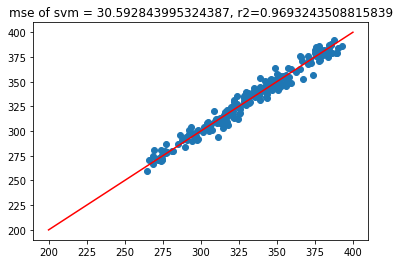

In [71]:
model4 = SVR(kernel='rbf', C=1000)
model4.fit(X_train, Y_train)
pred4 = model4.predict(X_test)

plt.scatter(Y_test, pred4)
plt.plot([200, 400], [200, 400], 'r')
plt.title(f'mse of svm = {mean_squared_error(Y_test, pred4)}, r2={r2_score(Y_test, pred4)}')

### 隨機森林模型

In [29]:
from sklearn.ensemble import RandomForestRegressor

Text(0.5, 1.0, 'mse of random forest = 37.31414999525357, r2=0.9625848524386524')

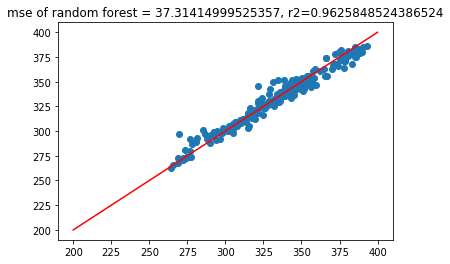

In [64]:
model5 = RandomForestRegressor(n_estimators=300)
model5.fit(X_train, Y_train)
pred5 = model5.predict(X_test)

plt.scatter(Y_test, pred5)
plt.plot([200, 400], [200, 400], 'r')
plt.title(f'mse of random forest = {mean_squared_error(Y_test, pred5)}, r2={r2_score(Y_test, pred5)}')

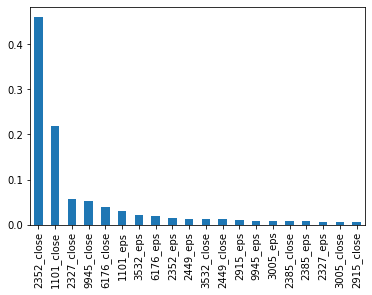

In [65]:
feat_importances = pd.Series(model5.feature_importances_, index=X_train.columns)
feat_importances.nlargest(50).plot(kind='bar')

### 把exam_part裡面的0056_close_y欄位刪除，因為本來就是空的，等一下要用F_test來考試

In [66]:
F_test = exam_part.drop('0056_close_y', axis = 1)

### 用模型來考試

In [72]:
final_model = model4
F_pred = final_model.predict(F_test) # F_pred 就是預測結果

### 把預測結果輸出成 result.csv，並上傳到 kaggle

In [73]:
F_pred = pd.DataFrame(F_pred)
F_pred.columns = ["prediction"]
F_pred.index = F_test.index
output=pd.DataFrame(data={"date":F_test.index,"0056_close_y":F_pred["prediction"]})
output.to_csv(path_or_buf="results.csv",index=False,quoting=3,sep=',')

### 觀察 result.csv的結果

In [74]:
output

,date,0056_close_y
date,,
7847,7847,375.321827
7848,7848,366.075709
7851,7851,362.340407
7852,7852,364.270726
7853,7853,359.996882
...,...,...
8082,8082,317.819061
8083,8083,322.402701
8084,8084,327.162400
